In [69]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [70]:
pip install -U langchain langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [71]:
LANGSMITH_TRACING="true"
LANGSMITH_API_KEY="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"

In [72]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

KeyboardInterrupt: Interrupted by user

In [ ]:
pip install -qU "langchain[openai]"

Note: you may need to restart the kernel to use updated packages.


In [51]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

### Open AI API Key

In [3]:
pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [52]:
import getpass
import os
from langchain_openai import ChatOpenAI

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

# Initialize the LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",  # Using a standard OpenAI model instead of gpt-4o-mini
    temperature=0
)

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

### In Memory Vector DB

In [ ]:
pip install -qU langchain-core

Note: you may need to restart the kernel to use updated packages.


In [3]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

### Astra DB Configurations

In [110]:
%pip install -qU langchain-astradb

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.


In [ ]:
from langchain_astradb import AstraDBVectorStore

vector_store = AstraDBVectorStore(
    embedding=embeddings,
    api_endpoint="https://b6cdce84-f7b6-4805-91e4-90521256cd86-us-east-2.apps.astra.datastax.com",
    collection_name="astra_vector_langchain",
    token="your_token",
    namespace="default_keyspace",
)

In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

In [ ]:
%pip install --quiet beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install --quiet langchain-community

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install --quiet langgraph

Note: you may need to restart the kernel to use updated packages.


In [54]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_community.document_loaders import PyPDFLoader

# Load and chunk contents of the blog
# loader = WebBaseLoader(
#     web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
#     bs_kwargs=dict(
#         parse_only=bs4.SoupStrainer(
#             class_=("post-content", "post-title", "post-header")
#         )
#     ),
# )

# List of PDF file paths
pdf_files = [
    "./Lecture1.pdf",
    "./Lecture2.pdf",
    "./Lecture3.pdf",
    "./lec1.pdf"
]

# Load all PDFs
all_docs = []
for file_path in pdf_files:
    loader = PyPDFLoader(file_path)
    docs = loader.load()
    all_docs.extend(docs)  # Combine documents from each PDF
    

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(all_docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [55]:
print(f"Loaded {len(all_docs)} documents")
for i, doc in enumerate(all_docs[:5]):
    print(f"[{i}] Source: {doc.metadata.get('source')}, Length: {len(doc.page_content)}")


Loaded 141 documents
[0] Source: ./Lecture1.pdf, Length: 50
[1] Source: ./Lecture1.pdf, Length: 286
[2] Source: ./Lecture1.pdf, Length: 22
[3] Source: ./Lecture1.pdf, Length: 60
[4] Source: ./Lecture1.pdf, Length: 573


In [56]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [57]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [59]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [60]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

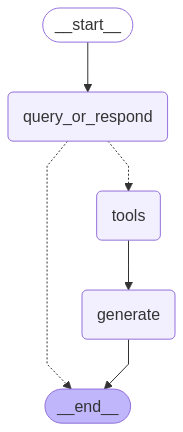

In [61]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

### Use an Agent to leverage the reasoning capabilities of LLMs

In [64]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

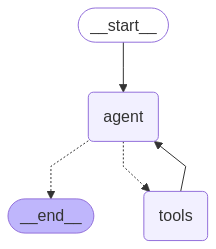

In [65]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [66]:
config = {"configurable": {"thread_id": "def234"}}


input_message = (
    "What is micorservice architecture\n\n"
)


for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is micorservice architecture


================================== Ai Message ==================================
Tool Calls:
  retrieve (call_20r460y9FIFa2Oq7KBYfg86E)
 Call ID: call_20r460y9FIFa2Oq7KBYfg86E
  Args:
    query: microservice architecture
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Microsoft® PowerPoint® for Microsoft 365', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'creationdate': '2025-05-06T19:39:14+05:30', 'title': 'PowerPoint Presentation', 'author': 'Microsoft Office User', 'moddate': '2025-05-06T19:39:14+05:30', 'source': './Lecture2.pdf', 'total_pages': 14, 'page': 10, 'page_label': '11'}
Content: Benefits of Microservices Architecture
Aspect Benefit Details
Enhanced Development and Maintenance
- Breaks application into smaller, manageable chunks.
- Clear boundaries with defined APIs.
- Quicker